In [1]:
!pip install hdbscan
!pip install sentence_transformers
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039291 sha256=594f9899fc189e8f5c13aa4f4f2c25150c54aaeda6cc852515c850b62dc7742a
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import tensorflow as tf

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel,pipeline

import hdbscan
from sklearn import metrics


from sentence_transformers import SentenceTransformer
import umap

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival
...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support
3076,How many countries do you support?,country_support
3077,What countries do you do business in?,country_support
3078,What are the countries you operate in.,country_support


In [4]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                   min_df=1,
                                   max_df=0.85,
                                   ngram_range=(1, 2))

In [6]:
X_tfidf = tfidf_vectorizer.fit_transform(test['text'])

In [7]:
X_tfidf.shape

(3080, 1000)

In [8]:
tfidf_matrix=X_tfidf.toarray()

In [9]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42)
umap_reduced = umap_model.fit_transform(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [10]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=0.0, cluster_selection_method='eom')
clusters = hdbscan_model.fit_predict(umap_reduced)

In [12]:
clusters

array([205, 182, 159, ...,  69,  82,  94])

In [22]:
test['topic'] = clusters
test

,text,category,topic
0,How do I locate my card?,card_arrival,205
1,"I still have not received my new card, I order...",card_arrival,182
2,I ordered a card but it has not arrived. Help ...,card_arrival,159
3,Is there a way to know when my card will arrive?,card_arrival,55
4,My card has not arrived yet.,card_arrival,159
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,6
3076,How many countries do you support?,country_support,-1
3077,What countries do you do business in?,country_support,69
3078,What are the countries you operate in.,country_support,82


<ipython-input-24-d00165adedfb>:8: UserWarning: 
The palette list has fewer values (250) than needed (252) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(x=umap_reduced[:, 0], y=umap_reduced[:, 1],hue=test['topic'],legend='full', alpha=0.8,palette=custom_palette)


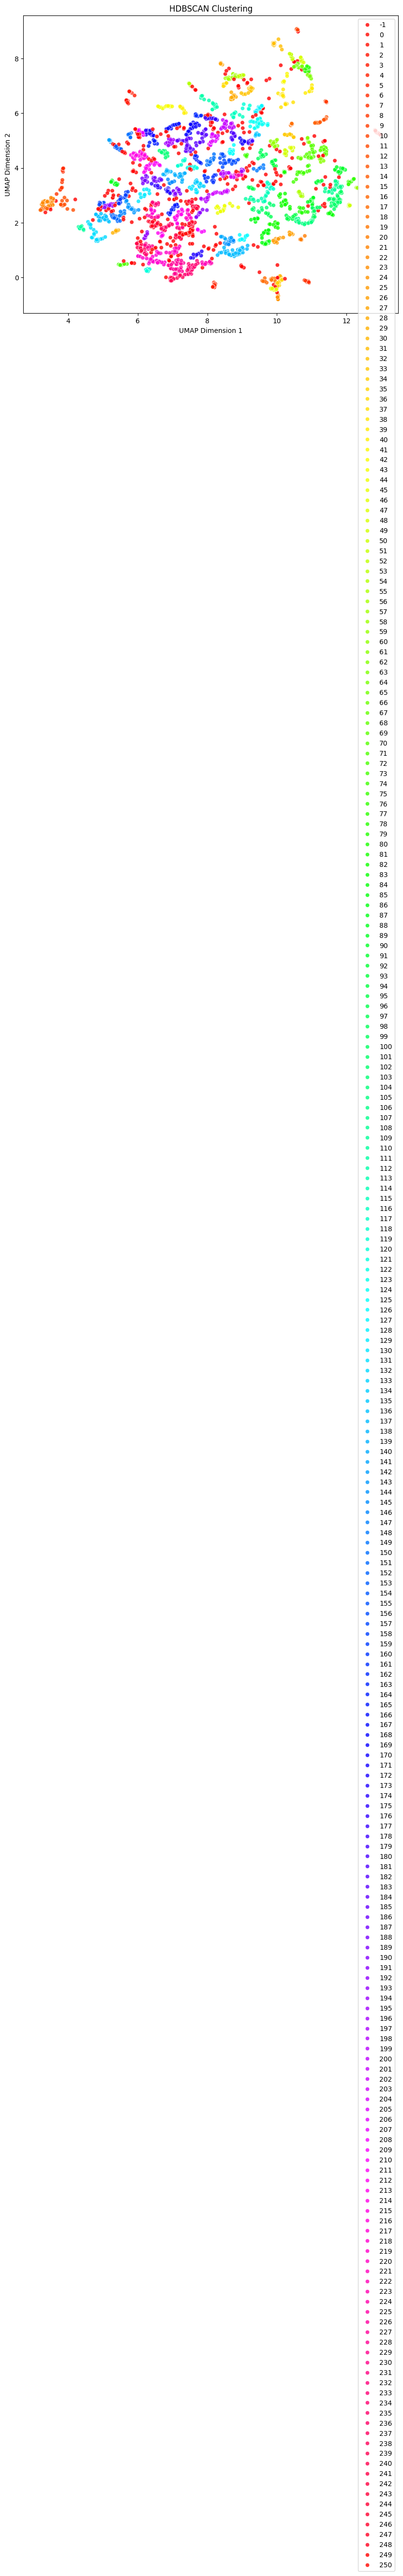

In [24]:
hues = np.linspace(0, 1, 250, endpoint=False)
saturation = 0.9
value = 0.9

custom_palette = [plt.cm.hsv(h) for h in hues]

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=umap_reduced[:, 0], y=umap_reduced[:, 1],hue=test['topic'],legend='full', alpha=0.8,palette=custom_palette)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()